In [28]:
import lmfit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pybroom as pb
from IPython.display import Math

plt.rcParams["text.usetex"] = True

import plot_function


def TC(x, ystress=1.0, eta_bg=0.1, gammadot_crit=0.1):
    """Three component model
    Note:
    .. math::
       \sigma=\sigma_y+\sigma_y\cdot(\dot\gamma/\dot\gamma_c)^{0.5}+\eta_{bg}\cdot\dot\gamma
    Args:
        ystress: yield stress [Pa]
        eta_bg : Background viscosity [Pa s]
        gammadot_crit : Critical shear rate [1/s]
    Returns:
        stress : Shear Stress, [Pa]
    """
    return ystress + ystress * (x / gammadot_crit) ** 0.5 + eta_bg * x


TC_model = lmfit.Model(TC, prefix="TC_")
""" Lmfit model from equation :meth:`rheofit.models.TC`
Note:
TC_model.set_param_hint('ystress', min=0)
TC_model.set_param_hint('eta_bg', min=0, vary=True)
TC_model.set_param_hint('gammadot_crit', min=0)
"""
TC_model.model_expression = Math(
    "\sigma=\sigma_y+\sigma_y\cdot(\dot\gamma/\dot\gamma_c)^{0.5}+\eta_{bg}\cdot\dot\gamma"
)

TC_model.set_param_hint("ystress", min=0)
TC_model.set_param_hint("eta_bg", min=0, vary=True)
TC_model.set_param_hint("gammadot_crit", min=0)


def HB(x, ystress=1.0, K=1.0, n=0.5):
    """Hershel-Bulkley Model
    Note:
    .. math::
       \sigma= \sigma_y + K \cdot \dot\gamma^n
    Args:
        ystress: yield stress [Pa]
        K : Consistency index [Pa s^n]
        n : Shear thinning index []
    Returns:
        stress : Shear Stress, [Pa]
    """
    return ystress + K * x**n


HB_model = lmfit.Model(HB, prefix="HB_")
""" Lmfit model from equation :meth:`rheofit.models.HB`
Note:
HB_model.set_param_hint('ystress', min=0)
HB_model.set_param_hint('K', min=0, vary=True)
HB_model.set_param_hint('n', min=0.0,max=1,vary=True)
"""

HB_model.model_expression = Math("\sigma=\sigma_y+K\cdot\dot\gamma^n")

HB_model.set_param_hint("ystress", min=0)
HB_model.set_param_hint("K", min=0, vary=True)
HB_model.set_param_hint("n", min=0.0, max=1, vary=True)


def make_generator(iterable):
    index = 0
    while True:
        yield iterable[index]
        index += 1

In [15]:
data_fig_6 = pd.read_csv("figure_6.csv", header=[0, 1])
data_fig_9 = pd.read_csv("figure_9.csv", header=[0, 1])

In [16]:
sample_label_list_fig6 = list(data_fig_6.columns.get_level_values(0).unique())
sample_label_list_fig9 = list(data_fig_9.columns.get_level_values(0).unique())

In [58]:
sample_label_dict_fig6 = {
    "G_8pc": "8\% carbopol in Glycerin",
    "G_5pc": "5\% carbopol in Glycerin",
    "G_3pc": "3\% carbopol in Glycerin",
    "PG_8pc": "8\% carbopol in Glycerin/PEG mixture",
    "PG_5pc": "5\% carbopol in Glycerin/PEG mixture",
    "PG_3pc": "3\% carbopol in Glycerin/PEG mixture",
    "P_8pc": "8\% carbopol in PEG",
    "P_5pc": "5\% carbopol in PEG",
    "P_3pc": "3\% carbopol in PEG",
}

sample_label_dict_fig9 = {
    "G_2pcCP": "2\% carbopol in Glycerin",
    "G_1p5pcCP": "1.5\% carbopol in Glycerin",
    "G_1pcCP": "1\% carbopol in Glycerin",
    "PG_2pcCP": "2\% carbopol in Glycerin/PEG mixture",
    "PG_1p5pcCP": "1.5\% carbopol in Glycerin/PEG mixture",
    "PG_1pcCP": "1\% carbopol in Glycerin/PEG mixture",
    "P_2pcCP": "2\% carbopol in PEG",
    "P_1p5pcCP": "1.5\% carbopol in PEG",
}

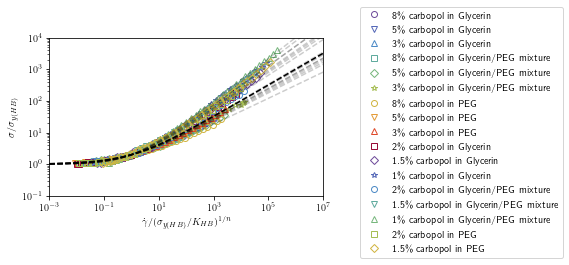

In [67]:
fig, ax, colors, markers = plot_function.create_plot()
fit_res_dict_HB={}

for sample_label in sample_label_list_fig6:
    data = data_fig_6.loc[:, data_fig_6.columns.get_level_values(0) == sample_label][
        sample_label
    ]
    fit = HB_model.fit(data["Y"], x=data["X"], weights=1 / data["Y"], nan_policy="omit")
    fit_res_dict_HB[sample_label]=fit

    x_rescale = (fit.best_values["HB_ystress"] / fit.best_values["HB_K"]) ** (
        1 / fit.best_values["HB_n"]
    )

    ax.plot(
        data["X"] / x_rescale,
        data["Y"] / fit.best_values["HB_ystress"],
        marker=next(markers),
        color=next(colors),
        linestyle="None",
        mfc="None",
        label=sample_label_dict_fig6[sample_label],
    )
    ax.set_yscale("log")
    ax.set_xscale("log")

for sample_label in sample_label_list_fig9:
    data = data_fig_9.loc[:, data_fig_9.columns.get_level_values(0) == sample_label][
        sample_label
    ]
    fit = HB_model.fit(data["Y"], x=data["X"], weights=1 / data["Y"], nan_policy="omit")
    fit_res_dict_HB[sample_label]=fit

    x_rescale = (fit.best_values["HB_ystress"] / fit.best_values["HB_K"]) ** (
        1 / fit.best_values["HB_n"]
    )

    ax.plot(
        data["X"] / x_rescale,
        data["Y"] / fit.best_values["HB_ystress"],
        marker=next(markers),
        color=next(colors),
        linestyle="None",
        mfc="None",
        label=sample_label_dict_fig9[sample_label],
    )
    ax.set_yscale("log")
    ax.set_xscale("log")

fit_res_table_HB=pb.tidy(fit_res_dict_HB).pivot(index='key',columns='name', values='value')    

ax.plot(np.logspace(-3, 8), 1 + np.logspace(-3, 8) ** 0.5, color="black", linestyle='--')

for n in fit_res_table_HB.HB_n:
    ax.plot(np.logspace(-3, 8), 1 + np.logspace(-3, 8) ** n, color="black", linestyle='--', alpha=0.2)


ax.set_xlabel("$\dot\gamma / (\sigma_{y(HB)}/K_{HB})^{1/n}$")
ax.set_ylabel("$\sigma / \sigma_{y(HB)}$")
fig.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
ax.set_xlim(0.001, 1e7)
ax.set_ylim(0.1, 1e4)
fig.savefig("HB mastercurve.svg", bbox_inches="tight")

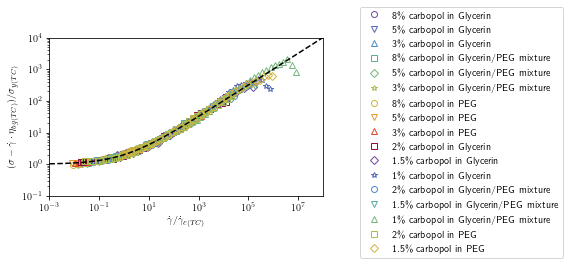

In [62]:
fig, ax, colors, markers = plot_function.create_plot()

for sample_label in sample_label_list_fig6:
    data = data_fig_6.loc[:, data_fig_6.columns.get_level_values(0) == sample_label][
        sample_label
    ]
    fit = TC_model.fit(data["Y"], x=data["X"], weights=1 / data["Y"], nan_policy="omit")

    x_rescale = fit.best_values["TC_gammadot_crit"]

    ax.plot(
        data["X"] / x_rescale,
        (data["Y"] - data["X"] * fit.best_values["TC_eta_bg"])
        / fit.best_values["TC_ystress"],
        marker=next(markers),
        color=next(colors),
        linestyle="None",
        mfc="None",
        label=sample_label_dict_fig6[sample_label],
    )
    ax.set_yscale("log")
    ax.set_xscale("log")

for sample_label in sample_label_list_fig9:
    data = data_fig_9.loc[:, data_fig_9.columns.get_level_values(0) == sample_label][
        sample_label
    ]
    fit = TC_model.fit(data["Y"], x=data["X"], weights=1 / data["Y"], nan_policy="omit")

    x_rescale = fit.best_values["TC_gammadot_crit"]

    ax.plot(
        data["X"] / x_rescale,
        (data["Y"] - data["X"] * fit.best_values["TC_eta_bg"])
        / fit.best_values["TC_ystress"],
        marker=next(markers),
        color=next(colors),
        linestyle="None",
        mfc="None",
        label=sample_label_dict_fig9[sample_label],
    )
    ax.set_yscale("log")
    ax.set_xscale("log")

ax.plot(np.logspace(-3, 8), 1 + np.logspace(-3, 8) ** 0.5, color="black", linestyle='--')

ax.set_xlabel("$\dot\gamma/\dot\gamma_{c(TC)}$")
ax.set_ylabel("$(\sigma - \dot\gamma \cdot \eta_{bg(TC)}) / \sigma_{y(TC)}$")
ax.set_xlim(0.001, 1e8)
ax.set_ylim(0.1, 1e4)
fig.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

fig.savefig("TC mastercurve.svg", bbox_inches="tight")